In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import os.path as path
import shutil
import pathlib
from pathlib import Path
from tqdm.std import tqdm
import random
import json
import random
import glob
import cv2
import regex as re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import enum
from enum import Enum, auto
import matplotlib as mpl
import sys
import spectral as spy

sys.path.insert(0, "..")
from yolo_visualize import (
    get_class_colors,
    show_image_with_bounding_box,
    sample_yolo_dataset,
)

In [2]:
PCB_VISION_ORIG_DATA_DIR = Path("./PCBVisionDataset/")

In [3]:
def sane_mkdir(v):
    if not path.isdir(v):
        os.mkdir(v)

In [4]:
PCB_VISION_YOLO_DIR = Path("./PCBVisionYolo")

In [5]:
CLASSES = [
    "IC",
    "Capacitor",
    "Connectors",
    "Other",
]

IC = 0
CAPACITOR = 1
CONNECTOR = 2
OTHER = 3

In [6]:
DATASET_GROUPS = ["train", "test", "valid"]

In [7]:
def rotate_copy(img, angle):
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows))

In [8]:
def get_pcb_rotation(pcb_mask):
    kernel = np.ones((10, 10), np.uint8)
    mask_smooth = pcb_mask
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_OPEN, kernel)
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_CLOSE, kernel)
    _, mask_smooth = cv2.threshold(
        mask_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # close everything inside
    contour, _ = cv2.findContours(mask_smooth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # get the biggest contour
    biggest_area = -1
    biggest = None
    for con in contour:
        area = cv2.contourArea(con)
        if biggest_area < area:
            biggest_area = area
            biggest = con
    rect = cv2.minAreaRect(biggest)
    angle = rect[2]
    if angle > 45:
        return -(90 - angle)
    return angle

In [9]:
def get_bounding_boxes_for_one_class(
    class_mask, joining_threshold: int, class_id: int
) -> list[tuple[int, float, float, float, float]]:
    full_h, full_w = class_mask.shape[:2]
    kernel = np.ones((joining_threshold, joining_threshold), np.uint8)
    mask_smooth = class_mask
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_OPEN, kernel)
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_CLOSE, kernel)
    _, mask_smooth = cv2.threshold(
        mask_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    contour, _ = cv2.findContours(mask_smooth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    dw = 1.0 / full_w
    dh = 1.0 / full_h

    # get the biggest contour
    res = []
    for con in contour:
        x, y, w, h = cv2.boundingRect(con)
        rel_x_center = (x + w / 2) * dw
        rel_y_center = (y + h / 2) * dh
        rel_width = w * dw
        rel_height = h * dh
        res.append((class_id, rel_x_center, rel_y_center, rel_width, rel_height))

    return res

In [10]:
def get_bounding_box_for_full_mask(
    component_mask,
) -> list[tuple[int, float, float, float, float]]:
    ic_mask = np.where(component_mask == 1, 255, 0).astype(np.uint8)
    capacitor_mask = np.where(component_mask == 2, 255, 0).astype(np.uint8)
    connector_mask = np.where(component_mask == 3, 255, 0).astype(np.uint8)
    others_mask = np.where(component_mask == 4, 255, 0).astype(np.uint8)
    return [
        *get_bounding_boxes_for_one_class(ic_mask, 5, IC),
        *get_bounding_boxes_for_one_class(capacitor_mask, 5, CAPACITOR),
        *get_bounding_boxes_for_one_class(connector_mask, 15, CONNECTOR),
        *get_bounding_boxes_for_one_class(others_mask, 5, OTHER),
    ]

In [12]:
i = 14

In [13]:
img_orig = cv2.imread(PCB_VISION_ORIG_DATA_DIR / "RGB" / (str(i) + ".jpg"))
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

In [14]:
# The PCB mask is faulty, it has extra padding on the sides, but it is inconsistent, so we can only use it to extract the angle
pcb_mask_faulty = cv2.imread(
    PCB_VISION_ORIG_DATA_DIR / "HSI" / "PCB_Masks" / (str(i) + ".jpg"),
    cv2.IMREAD_GRAYSCALE,
)

angle = get_pcb_rotation(pcb_mask_faulty)

img = rotate_copy(img_orig, angle)

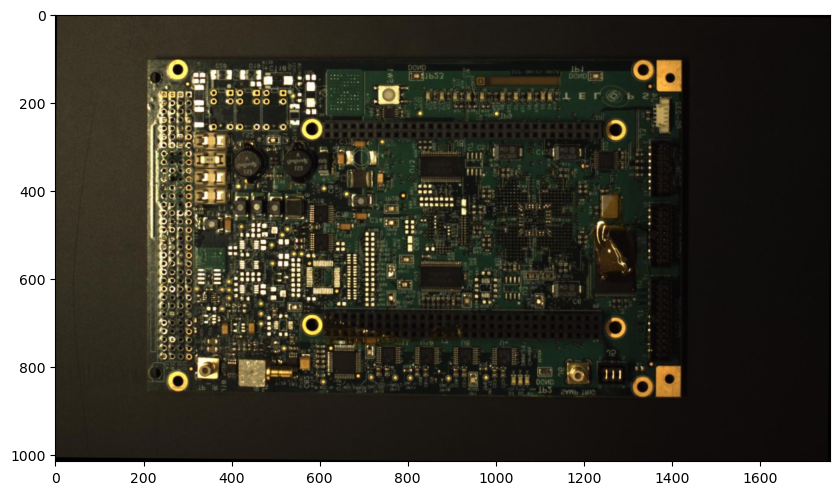

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [16]:
component_mask = cv2.imread(
    PCB_VISION_ORIG_DATA_DIR / "RGB" / "General" / (str(i) + ".png"),
    cv2.IMREAD_GRAYSCALE,
)

component_mask = rotate_copy(component_mask, angle)

In [17]:
bounding_boxes = get_bounding_box_for_full_mask(component_mask)

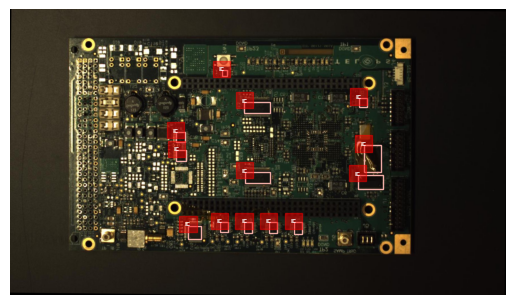

In [18]:
class_colors = get_class_colors(len(CLASSES))
show_image_with_bounding_box(plt.gca(), img, CLASSES, class_colors, bounding_boxes)

(-0.5, 1759.5, 1013.5, -0.5)

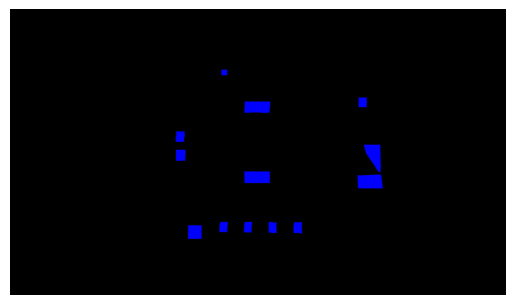

In [19]:
classes = {
    0: (0, 0, 0),
    (IC + 1): (1, 0, 0),
    (CAPACITOR + 1): (0, 1, 0),
    (CONNECTOR + 1): (0, 0, 1),
}
cmap = []
for i, x in enumerate(np.unique(component_mask)):
    cmap.append(classes[x])
cmap = mpl.colors.ListedColormap(cmap)
heatmap = (cmap(component_mask) * 255).astype(np.uint16)[:, :, :3]
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
plt.imshow(heatmap)
plt.axis("off")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].imshow(img)
ax[0].set_title("Original Image")
# img2 = (np.clip((((img - img.mean(axis=(0, 1))) / img.std(axis=(0, 1))) / 2), -2, 2) + 2) / 4 * 255

ax[1].imshow(img)
ax[1].set_title("Whitebalanced Image")

In [111]:
for range_val in range(1, 5+1):
    norm_img = (img - img.mean(axis=(0, 1))) / img.std(axis=(0, 1))
    min_v = np.clip(np.min(norm_img, axis=(0, 1)), -range_val, np.inf)
    max_v = np.clip(np.max(norm_img, axis=(0, 1)), -np.inf, range_val)
    img2 = ((np.clip(norm_img, min_v, max_v) - min_v)/(max_v - min_v) * 255).astype(np.uint8)
    j = Image.fromarray(img2)
    j.save(PCB_VISION_ORIG_DATA_DIR/f"z-clip-{range_val}-{i}.png")

In [107]:
for percentile_value in [25, 50, 75, 95, 97.5, 99]:
    whitebalanced = (
        (img * 1.0 / np.percentile(img, percentile_value, axis=(0, 1))).clip(0, 1) * 255
    ).astype(np.uint8)
    j = Image.fromarray(whitebalanced)
    j.save(PCB_VISION_ORIG_DATA_DIR/f"percentile-{percentile_value}-{i}.png")

In [ ]:
def percentile_whitebalance(image, percentile_value):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    for channel, color in enumerate("rgb"):
        channel_values = image[:, :, channel]
        value = np.percentile(channel_values, percentile_value)
        ax.step(
            np.arange(256),
            np.bincount(channel_values.flatten(), minlength=256)
            * 1.0
            / channel_values.size,
            c=color,
        )
        ax.set_xlim(0, 255)
        ax.axvline(value, ls="--", c=color)
        ax.text(
            value - 70,
            0.01 + 0.012 * channel,
            "{}_max_value = {}".format(color, value),
            weight="bold",
            fontsize=10,
        )
    ax.set_xlabel("channel value")
    ax.set_ylabel("fraction of pixels")
    ax.set_title("Histogram of colors in RGB channels")
    plt.show()
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 16))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    whitebalanced = (
        (image * 1.0 / np.percentile(image, percentile_value, axis=(0, 1))).clip(0, 1) * 255
    ).astype(np.uint8)
    ax[1].imshow(whitebalanced)
    ax[1].set_title("Whitebalanced Image")
    plt.show()

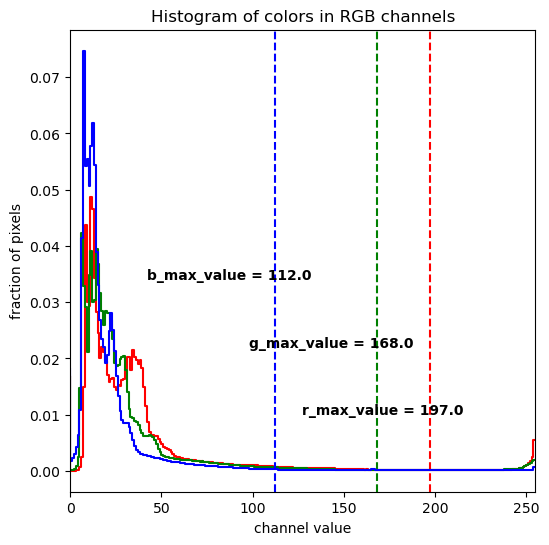

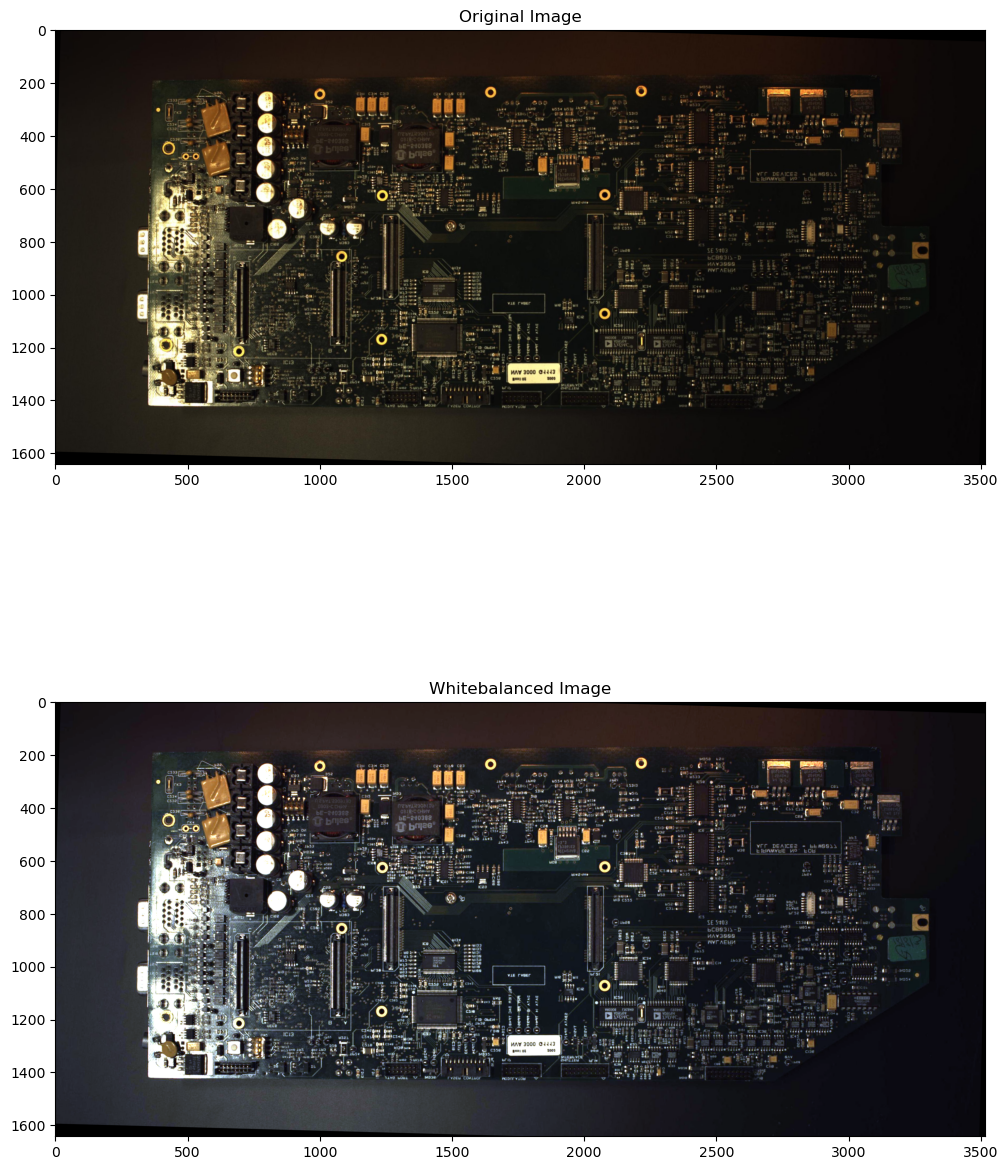

In [68]:
percentile_whitebalance(img, 97.5)

Text(0.5, 1.0, 'Whitebalanced Image')

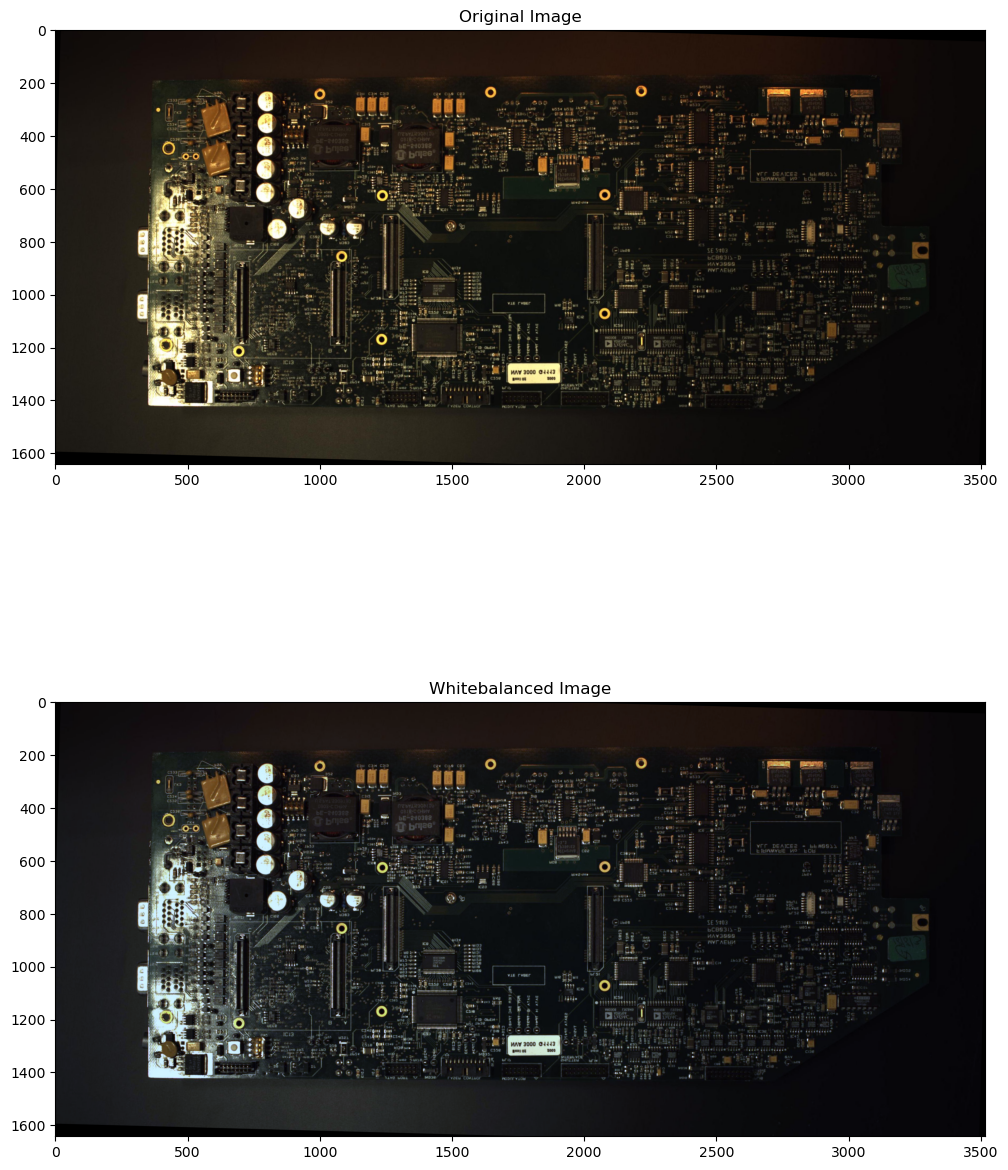

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].imshow(img2)
ax[1].set_title("Whitebalanced Image")